In [26]:
# Let's begin!

# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import re
from pprint import pprint
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [27]:
# Importing dataset
df = pd.read_excel('data/Incidents_data_till_May 2019.xlsx')

In [28]:
# PRE-CLEANING DATASET
# Drop useless columns
df_init = df.drop(columns=[
                 'Group Name',
                 'Incident ID', 
                 'State how the incident was detected', 
                 'Reporting Currency',
                 'Gross Amount in Reporting Currency',
                 'Recovery Amount in Reporting Currency',
                 'Net Loss - Reporting Currency', 
                 'Transaction Currency',
                 'Gross Amount in Transaction Currency',
                 'Recovery Amount in Transaction Currency',
                 'Net Loss - Transaction Currency', 
                 'Actual Currency',
                 'Gross Amount in Actual Currency', 
                 'Incident Gross Amount' , 
                 'Eff GL Account No.', 
                 'Eff GL Reference', 
                 'Rcvy GL Reference', 
                 'Incident Owner',
                 'Justification',
                 'FCSS Assessment Results',
                 'System involved',
                 'Justification for no GL information'
                 ])

# Getting only APPROVED or CLOSED incidents
df_init = df_init[(df_init['Incident Status'] == 'CLOSED') | (df_init['Incident Status'] == 'APPROVED')]

# DateTime Operations
df_init['Creation Year'] = pd.DatetimeIndex(df_init['Creation date']).year
df_init['Creation Month'] = pd.DatetimeIndex(df_init['Creation date']).month

# Removing 2019 year records as the it is the current year
df_init = df_init[df_init['Creation Year'] != 2019]

# Filling the NAN values in Amounts column
df_init['Gross Amount in SGD'].fillna(value=0, inplace=True)
df_init['Recovery Amount in SGD'].fillna(value=0, inplace=True)
df_init['Net Loss - SGD'].fillna(value=0, inplace=True)

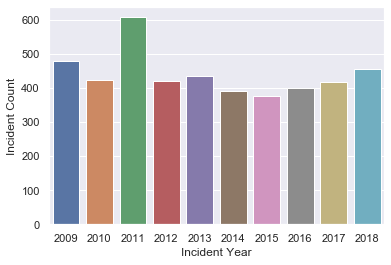

In [30]:
# Visualizing Data Incidents V/S Year
incidentGroupedByYear = pd.DataFrame(df_init.groupby('Creation Year').agg('count')['Creation date'])
incidentGroupedByYear.reset_index(inplace=True)
incidentGroupedByYear.rename(columns={'Creation date': 'Incident Count', 'Creation Year': 'Incident Year'}, inplace=True)
sns.set()
sns.barplot(x="Incident Year", y="Incident Count", data=incidentGroupedByYear);

In [31]:
incidentGroupedByYear

,Incident Year,Incident Count
0,2009,479
1,2010,423
2,2011,607
3,2012,421
4,2013,434
5,2014,390
6,2015,376
7,2016,400
8,2017,417
9,2018,454


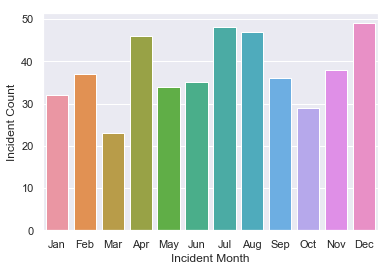

In [134]:
# Visualizing for the year of 2018
incidentsFor2018 = df_init[df_init['Creation Year'] == 2018]
incidentsGroupedByMonth = pd.DataFrame(incidentsFor2018.groupby('Creation Month').agg('count')['Creation date'])
incidentsGroupedByMonth.reset_index(inplace=True)
incidentsGroupedByMonth.rename(columns={'Creation Month': 'Incident Month', 'Creation date': 'Incident Count'}, inplace=True)
incidentsGroupedByMonth['Incident Month'] = incidentsGroupedByMonth['Incident Month'].apply(lambda x: calendar.month_abbr[x])
sns.set()
sns.barplot(x="Incident Month", y="Incident Count", data=incidentsGroupedByMonth);

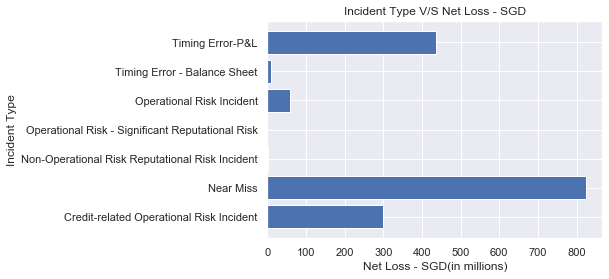

Incident Type
Near Miss                                           825.029261
Timing Error-P&L                                    437.440520
Credit-related Operational Risk Incident            300.024498
Operational Risk Incident                            57.994271
Timing Error - Balance Sheet                          9.563933
Non-Operational Risk Reputational Risk Incident       0.781620
Operational Risk - Significant Reputational Risk      0.058605
Name: Net Loss - SGD, dtype: float64


In [32]:
# Visualizing for Incident Types V/S Net Loss - SGD
netLoss = df_init.groupby('Incident Type').sum()['Net Loss - SGD']
netLoss = netLoss/1000000
plt.barh(netLoss.index, netLoss)
plt.ylabel('Incident Type')
plt.xlabel('Net Loss - SGD(in millions)')
plt.title('Incident Type V/S Net Loss - SGD')
plt.show()
print(netLoss.nlargest(8))

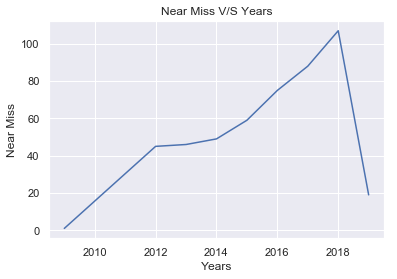

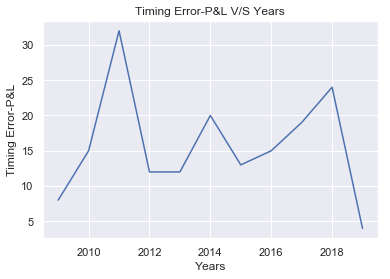

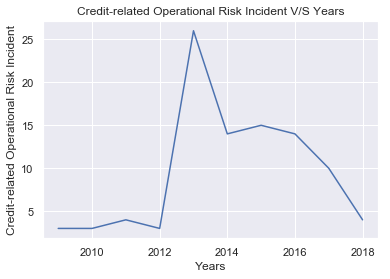

In [136]:
# Visualizing for Incident Type V/S Year
inciArr = ['Near Miss', 'Timing Error-P&L', 'Credit-related Operational Risk Incident']
for i in inciArr:
    q = df_init[df_init['Incident Type'] == i].groupby('Creation Year').count()['Incident Type']
    plt.plot(q.index, q)
    plt.ylabel(i)
    plt.xlabel('Years')
    plt.title(i + ' V/S Years')
    plt.show()

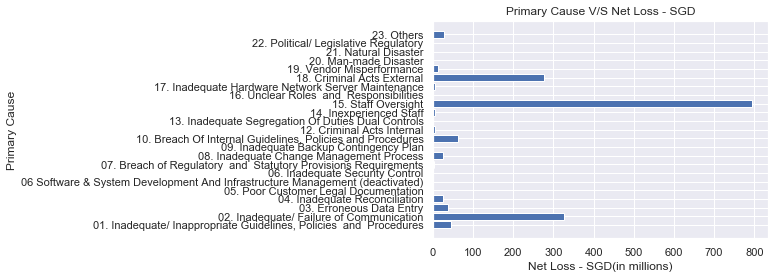

Primary Cause
15. Staff Oversight                                                    793.775419
02. Inadequate/ Failure of Communication                               326.434192
18. Criminal Acts External                                             276.079128
10. Breach Of Internal Guidelines, Policies and Procedures              62.876402
01. Inadequate/ Inappropriate Guidelines, Policies  and  Procedures     43.947286
Name: Net Loss - SGD, dtype: float64


In [137]:
# Visualizing for Primary Cause V/S Net Loss - SGD
netLoss_x = df_init.groupby('Primary Cause').sum()['Net Loss - SGD']
netLoss_x = netLoss_x/1000000
plt.barh(netLoss_x.index, netLoss_x)
plt.ylabel('Primary Cause')
plt.xlabel('Net Loss - SGD(in millions)')
plt.title('Primary Cause V/S Net Loss - SGD')
plt.show()
print(netLoss_x.nlargest(5))

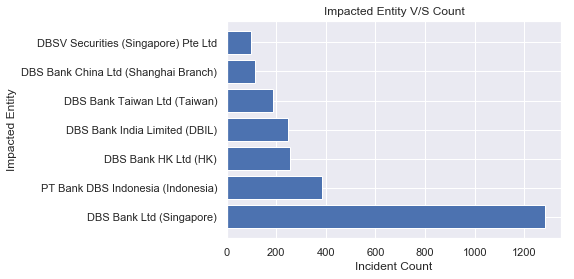

Impacted Entity
DBS Bank Ltd (Singapore)                1286
PT Bank DBS Indonesia (Indonesia)        384
DBS Bank HK Ltd (HK)                     256
DBS Bank India Limited (DBIL)            246
DBS Bank Taiwan Ltd (Taiwan)             186
DBS Bank China Ltd (Shanghai Branch)     116
DBSV Securities (Singapore) Pte Ltd       97
Name: Incident Type, dtype: int64


In [80]:
# Visualizing Impacted Entity
impacted_df = df_init[df_init['Impacted Entity'].notna()]
impacted_df.groupby('Impacted Entity').count()['Incident Type']
top_impacted_df = impacted_df.groupby('Impacted Entity').count()['Incident Type'].sort_values(ascending=False)
top_impacted_df = top_impacted_df.nlargest(7)
plt.barh(top_impacted_df.index, top_impacted_df)
plt.ylabel('Impacted Entity')
plt.xlabel('Incident Count')
plt.title('Impacted Entity V/S Count')
plt.show()
print(top_impacted_df)

In [129]:
# Mapping Incidents to Issues&Actions
inci = pd.read_excel('data/Incidents_data_till_May 2019.xlsx')
issueAction = pd.read_excel('data/IssuesNActions_MIS_May2019-m.xlsx', sheet_name='Issue & Action Report')
issuetoSource = pd.read_excel('data/IssuesNActions_MIS_May2019-m.xlsx', sheet_name='Issue to Source')

In [131]:
# PRE CLEANING

# Clean Issues and Actions
issueAction_df = issueAction.copy(deep=True)
issueAction_df.columns = issueAction_df.iloc[12]
issueAction_df = issueAction_df.iloc[11:,:]
issueAction_df.reset_index(drop=True, inplace=True)

issueAction_df_nlp = issueAction_df[['IssueID', 'IssueType', 'IssueName', '(MASKED) IssueDescription', 'ActionName', 'ActionDescription']]
issueAction_df_nlp = issueAction_df_nlp.dropna()

issuetoSource = issuetoSource[issuetoSource['Source Module'] == 'INCIDENT']

issueAction_df_nlp_final = pd.merge(issuetoSource, issueAction_df_nlp, on='IssueID')
issueAction_df_nlp_final.drop(columns=['Source Module'], inplace=True)
issueAction_df_nlp_final.rename(columns={'Source ID': 'Incident ID'}, inplace=True)

In [137]:
# Clean Incidents
inci_df_nlp = inci.copy(deep=True)
inci_df_nlp
inci_df_nlp = inci_df_nlp[['Incident ID', 'Incident Type', '(MASKED) Describe what happened', 'State how the incident was detected', 'Initial steps taken to address incident', 'Root Cause Description', 'Controls Implemented for Selected Cause']]

In [138]:
# Merge Incidents and Issues
inci_issue_nlp = pd.merge(inci_df_nlp, issueAction_df_nlp_final, on='Incident ID')

In [139]:
# Export to Excel
inci_issue_nlp.to_excel('data/Incidents-Issues-Action.xlsx')

In [140]:
# Drop NAN and reset index
inci_issue_nlp = inci_issue_nlp.dropna()
inci_issue_nlp.reset_index(drop=True, inplace=True)

In [141]:
inci_issue_nlp

,Incident ID,Incident Type,(MASKED) Describe what happened,State how the incident was detected,Initial steps taken to address incident,Root Cause Description,Controls Implemented for Selected Cause,IssueID,IssueType,IssueName,(MASKED) IssueDescription,ActionName,ActionDescription
0,IM10495357,Operational Risk Incident,Customer called our hotline on 24 Mar 09 at 15...,Refer to Incident Description,Refer to Incident Description,Staff Oversight,Refer to Root Cause Description,IAM113703,Incident,10495357 - Agent oversight to confirm instruct...,Agent oversight to confirm instruction receipt...,113703 - People,"Due to oversight, staff wrongly replied instru..."
1,IM10514094,Operational Risk Incident,Per investigation report issued by CSS on June...,Refer to Incident Description,Refer to Incident Description,data quality,Refer to Root Cause Description,IAM128502,Incident,RM-conflict of Interest and Code of conduct vi...,1) RM should not directly involve himself or ...,"Reinforce Code of Coduct, etc.",1.F&D has completed an internal review and RM ...
2,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
3,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
4,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
5,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
6,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
7,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
8,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",Refer to Incident Description,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,S

In [125]:
inci_issue_nlp['(MASKED) Describe what happened'].iloc[0]

'Customer called our hotline on 24 Mar 09 at 15:01 to enquire whether the Bank has recevied his fax regarding the confirmation of HSBC right issue. TRE staff replied customer that we have to wait for the information upload and needed to reply to her on next day. Customer accepted our arrangement and requested the TRE staff to call back her brother to confirm whether we have received the fax.  TRE staff called back her brother on 25 Mar 09 at 14:01 and confirmed that we have already received the fax.  On 24 Apr 09 customer called again and stated that we did not helped her to exercise the HSBC rights. After checked with the record file from IVSO (no received record) and listened to tape records between TRE and customer on 25 Mar, we identified that due to oversight, TRE staff was providing a wrong answer to customer.  As per approval by team head, we have to buy back 4,166 shares of HSBC (0005) for customer on 24 Apr 09, the order was completed at $52.348 (average price).  We have credi

In [126]:
# Let's begin NLP!

In [11]:
# Cleaning descriptions

In [9]:
# Tokenize and Lemmatize
def textAnalyze(text):
    text=text.lower()
    tokenized_word=word_tokenize(text)
    stop_words=set(stopwords.words("english"))
    filtered_sent=[]
    for w in tokenized_word:
        if w not in stop_words:
            filtered_sent.append(w)
    lem = WordNetLemmatizer()
    lematized_words=[]
    for w in filtered_sent:
        lematized_words.append(lem.lemmatize(w,"v"))
    finalWords=[]    
    for w in lematized_words:
        try:
            width = float(w)   
        except ValueError:
            finalWords.append(w)
    finalWords = ' '.join(finalWords)
    return finalWords

In [59]:
# Initialize corpus
corpus_inci_desc = []

In [60]:
# Process Incident Description
for i in range(0, inci_issue_nlp.shape[0]):
    desc = re.sub('[^a-zA-Z]', ' ', inci_issue_nlp['(MASKED) Describe what happened'][i])
    corpus_inci_desc.append(textAnalyze(desc))

In [102]:
# Creating the Bag of Words
# Using CountVectorizer
cv = CountVectorizer(max_features=4000, ngram_range=(1,3))
x_inci_desc = cv.fit_transform(corpus_inci_desc).toarray()

# Using Term Frequency Inverse Document Frequency
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1,3))
tx_inci_desc = tfidf.fit_transform(corpus_inci_desc).toarray()

feature_names = cv.get_feature_names()
feature_matrix_cv = pd.DataFrame(x_inci_desc, columns=feature_names)
feature_matrix_tfidf = pd.DataFrame(tx_inci_desc, columns=feature_names)

In [142]:
feature_matrix_cv

,abc,abended,abended job,able,absorb,ac,accept,acceptance,acceptance test,acceptance test result,...,xxxx,xxxxxxx,year,year period,year period nov,years,years experience,years old,yet,zero
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
# Prepare string for wordcloud
word = ' '.join(corpus_inci_desc)
word = word.replace('customer', '')
word = word.replace('bank', '')
word = word.replace('account number', '')
word = word.replace('account', '')
word = word.replace('client', '')
word = word.replace('day', '')

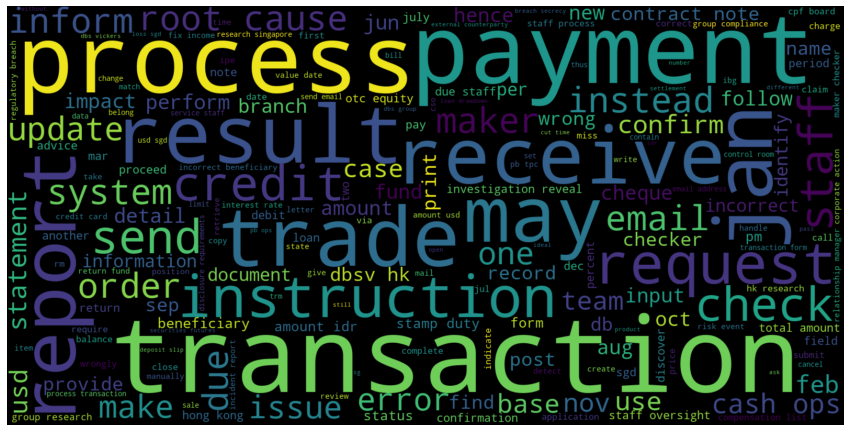

In [183]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='black').generate(word)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Action Cleaning
inci_issue_nlp.loc[inci_issue_nlp['State how the incident was detected'] == 'Refer to Incident Description', 'State how the incident was detected'] = np.nan

In [210]:
# Prepare corpus
corpus_action = []
# Process Action Name
for i in range(0, inci_issue_nlp.shape[0]):
    desc = re.sub('[^a-zA-Z]', ' ', inci_issue_nlp['ActionName'][i])
    corpus_action.append(textAnalyze(desc))

In [211]:
len(inci_issue_nlp['ActionName'].unique())

921

In [212]:
inci_issue_nlp

,Incident ID,Incident Type,(MASKED) Describe what happened,State how the incident was detected,Initial steps taken to address incident,Root Cause Description,Controls Implemented for Selected Cause,IssueID,IssueType,IssueName,(MASKED) IssueDescription,ActionName,ActionDescription
0,IM10495357,Operational Risk Incident,Customer called our hotline on 24 Mar 09 at 15...,NaN,Refer to Incident Description,Staff Oversight,Refer to Root Cause Description,IAM113703,Incident,10495357 - Agent oversight to confirm instruct...,Agent oversight to confirm instruction receipt...,113703 - People,"Due to oversight, staff wrongly replied instru..."
1,IM10514094,Operational Risk Incident,Per investigation report issued by CSS on June...,NaN,Refer to Incident Description,data quality,Refer to Root Cause Description,IAM128502,Incident,RM-conflict of Interest and Code of conduct vi...,1) RM should not directly involve himself or ...,"Reinforce Code of Coduct, etc.",1.F&D has completed an internal review and RM ...
2,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
3,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
4,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
5,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
6,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
7,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
8,IM10546605,Operational Risk Incident,"Clean Overdraft Limit : $18,000 . Customer pr...",NaN,Refer to Incident Description,Staff has been counselled and given warning on...,Refer to Root Cause Description,IAM24691029,Incident,Staffs oversight to return the cheques,"Overdraft Limit : $18,000 Customer presented ...",Staff oversight to return cheques,Staff were counselled and the process were re-...
9,IM24217859,Operational Risk Incident,In completing report LBU Form 24 (Saving Produ...,NaN,Corrective Action : Report as per Bank Indones...,Lack of understanding on the prevailing re

In [190]:
1125-921

204

In [213]:
word2 = ' '.join(corpus_action)
word2 = word2.replace('customer', '')
word2 = word2.replace('bank', '')
word2 = word2.replace('account number', '')
word2 = word2.replace('account', '')
word2 = word2.replace('client', '')
word2 = word2.replace('day', '')
word2 = word2.replace('process', '')
word2 = word2.replace('complete', '')
word2 = word2.replace('report', '')
word2 = word2.replace('team', '')


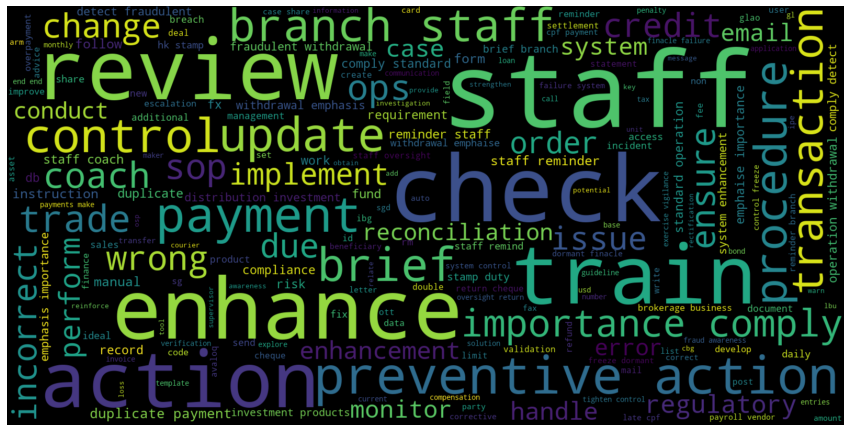

In [214]:
wordcloud2 = WordCloud(width=1600, height=800, max_font_size=200, background_color='black').generate(word2)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [215]:
# Creating the Bag of Words
# Using CountVectorizer
cv2 = CountVectorizer(max_features=4000, ngram_range=(1,3))
x_action_desc = cv2.fit_transform(corpus_action).toarray()

# Using Term Frequency Inverse Document Frequency
tfidf2 = TfidfVectorizer(max_features=4000, ngram_range=(1,3))
tx_action_desc = tfidf2.fit_transform(corpus_action).toarray()

feature_names2 = cv2.get_feature_names()
feature_matrix_cv2 = pd.DataFrame(x_action_desc, columns=feature_names2)
feature_matrix_tfidf2 = pd.DataFrame(tx_action_desc, columns=feature_names2)

In [216]:
corpus_action

['people',
 'reinforce code coduct etc',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'staff oversight return cheque',
 'automate process create lbu form',
 'lbu report',
 'process relate party',
 'potential loss eur',
 'ideal long term solution',
 'incentive payments leap',
 'submission revise lbu form',
 'lbu report automation',
 'amend system design fx transaction internet bank trade hours',
 'ibg staff complaint',
 'monitor system phone record',
 'train documentation sales staff',
 'correction lbu form feb report',
 'update sop payment',
 'investigation vendor stb microsoft access problem',
 'workaround solution',
 'guidance fill excel sid form data',
 'system upload data stb sid automatically',
 'sid automation project',
 'sid automation project',
 'reiterate team vigilant perform task',
 'revise sop train staff vendor',
 '

In [249]:
# Trial 2

In [250]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [286]:
# Convert to list
data = []

# Considering only alphabets
for i in range(0, inci_issue_nlp.shape[0]):
    desc = re.sub('[^a-zA-Z]', ' ', inci_issue_nlp['ActionDescription'][i])
    desc = re.sub("\'", "", desc)
    desc = re.sub(' +', ' ', desc)
    data.append(desc)

pprint(data)

['Due to oversight staff wrongly replied instruction receipt status to '
 'customer Action taken Buy back shares of HSBC stock at average price on '
 'April Operation Loss for debited from Operating Loss account on April '
 'Supervisor warned relevant staff to pay more attention on customers '
 'enquiries and laid down procedures completed on Apr Incoming calls of '
 'Securities trading for relevant staff was suspensed for two weeks Warning '
 'letter was issued by HR to relevant staff on Apr ',
 ' F D has completed an internal review and RM who takes care of his relatives '
 'should shift the these customers to another RM CBG outdoor account opening '
 'procedure has been modified accordingly The training on ethical selling has '
 'been provided to RMs All of the staffs have signed the annual '
 'acknowledgement after reading and understanding the Code of Conduct ',
 'Staff were counselled and the process were re aligned to a centralised '
 'department',
 'Staff were counselled and th

 'to Regional Cash for Release',
 'Action Plans Bank requested the fund house to buy back the excess units '
 'Completed Remove staff from the role of checker Completed Conduct a huddle '
 'session to reinforce the SOP and to remind staff to be diligent with the '
 'work Completed To set up an independent team under CBO UT to check inquiries '
 'received from branches and to ensure that reconciliation has been done '
 'before the redemption batch form is send to the investment manager fund '
 'house TCD Feb Implement the following improvements CBO to obtain positive '
 'confirmation from branches on instructions processed TCD Jan Branch to '
 'obtain confirmation from CBO for all amendments made TCD Jan Specify the '
 'date when branch should reconfirm to CBO the consolidated instructions from '
 'CBO TCD Jan Set up a master register of bring up instruction for outstanding '
 'unsettled transactions TCD Feb Improvements to instruction delivery process '
 'will be part of DBSI T O Autom

 'RM to act on trade instruction asap after receiving it from client When RM '
 'is off premises and where possible a way conference call RM ARM and client '
 'to be conducted when taking orders from client ',
 'Branch Service Manager has shared the incident with all staff and reiterated '
 'on the importance of checking and ensuring that the deposit is credited to '
 'the correct customer account Staff are reminded to tally the account name '
 'and number on the system screen against customer s instruction before '
 'transmitting the transaction and to verify the printing on the deposit slip '
 'before releasing it to the customer to ensure accuracy Action Owner BSM Yeo '
 'Soo Kiong ',
 ' System enhancement will be launched in Q to reduce human errors revise '
 'report generation logic to extract all transactions based on input date '
 'instead of transaction date so that retrospective inputted cases will also '
 'be captured in next day s report use real time exchange rate at time o

In [287]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['due', 'to', 'oversight', 'staff', 'wrongly', 'replied', 'instruction', 'receipt', 'status', 'to', 'customer', 'action', 'taken', 'buy', 'back', 'shares', 'of', 'hsbc', 'stock', 'at', 'average', 'price', 'on', 'april', 'operation', 'loss', 'for', 'debited', 'from', 'operating', 'loss', 'account', 'on', 'april', 'supervisor', 'warned', 'relevant', 'staff', 'to', 'pay', 'more', 'attention', 'on', 'customers', 'enquiries', 'and', 'laid', 'down', 'procedures', 'completed', 'on', 'apr', 'incoming', 'calls', 'of', 'securities', 'trading', 'for', 'relevant', 'staff', 'was', 'suspensed', 'for', 'two', 'weeks', 'warning', 'letter', 'was', 'issued', 'by', 'hr', 'to', 'relevant', 'staff', 'on', 'apr']]


In [288]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['due', 'to', 'oversight', 'staff', 'wrongly', 'replied', 'instruction', 'receipt', 'status', 'to', 'customer', 'action', 'taken', 'buy', 'back', 'shares', 'of', 'hsbc', 'stock', 'at', 'average', 'price', 'on', 'april', 'operation', 'loss', 'for', 'debited', 'from', 'operating', 'loss', 'account', 'on', 'april', 'supervisor', 'warned', 'relevant', 'staff', 'to', 'pay', 'more', 'attention', 'on', 'customers', 'enquiries', 'and', 'laid', 'down', 'procedures', 'completed', 'on', 'apr', 'incoming', 'calls', 'of', 'securities', 'trading', 'for', 'relevant', 'staff', 'was', 'suspensed', 'for', 'two', 'weeks', 'warning_letter', 'was', 'issued', 'by', 'hr', 'to', 'relevant', 'staff', 'on', 'apr']


In [289]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [290]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['due', 'oversight', 'staff', 'wrongly', 'reply', 'instruction', 'receipt', 'status', 'customer', 'action', 'take', 'buy', 'back', 'share', 'hsbc', 'stock', 'average', 'price', 'april', 'operation', 'loss', 'debit', 'operate', 'loss', 'account', 'april', 'supervisor', 'warn', 'relevant', 'staff', 'pay', 'attention', 'customer', 'enquiry', 'lay', 'procedure', 'complete', 'apr', 'incoming', 'call', 'security', 'trading', 'relevant', 'staff', 'suspense', 'week', 'warning_letter', 'issue', 'relevant', 'staff', 'apr']]


In [291]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 4), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]]


In [292]:
id2word[0]

'account'

In [293]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('account', 1),
  ('action', 1),
  ('apr', 2),
  ('april', 2),
  ('attention', 1),
  ('average', 1),
  ('back', 1),
  ('buy', 1),
  ('call', 1),
  ('complete', 1),
  ('customer', 2),
  ('debit', 1),
  ('due', 1),
  ('enquiry', 1),
  ('hsbc', 1),
  ('incoming', 1),
  ('instruction', 1),
  ('issue', 1),
  ('lay', 1),
  ('loss', 2),
  ('operate', 1),
  ('operation', 1),
  ('oversight', 1),
  ('pay', 1),
  ('price', 1),
  ('procedure', 1),
  ('receipt', 1),
  ('relevant', 3),
  ('reply', 1),
  ('security', 1),
  ('share', 1),
  ('staff', 4),
  ('status', 1),
  ('stock', 1),
  ('supervisor', 1),
  ('suspense', 1),
  ('take', 1),
  ('trading', 1),
  ('warn', 1),
  ('warning_letter', 1),
  ('week', 1),
  ('wrongly', 1)]]

In [294]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [295]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.102*"advice" + 0.099*"group" + 0.061*"event" + 0.056*"block" + '
  '0.055*"escalate" + 0.035*"quantity" + 0.033*"point" + 0.028*"reference" + '
  '0.024*"immediately" + 0.023*"tighten"'),
 (1,
  '0.126*"cbg" + 0.115*"place" + 0.071*"screen" + 0.067*"key" + 0.026*"blind" '
  '+ 0.022*"design" + 0.008*"commission" + 0.008*"house_procedure" + '
  '0.008*"management_briefing" + 0.000*"adhere"'),
 (2,
  '0.248*"staff" + 0.136*"complete" + 0.081*"remind" + 0.046*"instruction" + '
  '0.045*"perform" + 0.043*"coach" + 0.037*"manual" + 0.035*"take" + '
  '0.035*"action" + 0.034*"processing"'),
 (3,
  '0.143*"share" + 0.099*"contact" + 0.051*"fraud_awareness" + 0.047*"company" '
  '+ 0.036*"revise" + 0.024*"person" + 0.015*"authorize" + 0.011*"discussion" '
  '+ 0.010*"refresher_training" + 0.004*"withdrawal"'),
 (4,
  '0.106*"action" + 0.085*"review" + 0.074*"client" + 0.061*"fee" + '
  '0.050*"new" + 0.047*"business" + 0.047*"product" + 0.047*"bank" + '
  '0.046*"issue" + 0.039*"risk

In [296]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -15.09625851364738

Coherence Score:  0.34222793567254484


In [297]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.190407  0.281036       1        1  12.530825
4     -0.233660 -0.218511       2        1  11.244482
2     -0.221162 -0.081468       3        1   9.609654
11    -0.151100 -0.054240       4        1   8.977473
15    -0.090134  0.173100       5        1   8.558373
17    -0.095118 -0.090730       6        1   8.071808
16    -0.050017  0.021977       7        1   6.167257
10    -0.012796  0.153027       8        1   5.209317
7     -0.011391 -0.035078       9        1   4.723202
18     0.009388 -0.051676      10        1   4.564123
12     0.072291 -0.001086      11        1   3.819782
13     0.071436 -0.006301      12        1   3.712853
9      0.043189  0.028728      13        1   3.468244
6      0.110024 -0.016245      14        1   1.784069
14     0.105305 -0.025998      15        1   1.716225
0      0.120867 -0.015851      16        1   1.607256
8      0.117267 -0.015914      17        1   1.573373
3      0.140123 -0.013603      18        1   0.938914
1      0.132620 -0.015651      19        1   0.935365
19     0.133274 -0.015515      20        1   0.787402, topic_info=     Category        Freq              Term       Total  loglift  logprob
31    Default  686.000000             staff  686.000000  30.0000  30.0000
10    Default  633.000000          customer  633.000000  29.0000  29.0000
66    Default  453.000000           process  453.000000  28.0000  28.0000
186   Default  392.000000              team  392.000000  27.0000  27.0000
308   Default  345.000000             check  345.000000  26.0000  26.0000
9     Default  448.000000          complete  448.000000  25.0000  25.0000
216   Default  310.000000                op  310.000000  24.0000  24.0000
151   Default  278.000000            system  278.000000  23.0000  23.0000
317   Default  279.000000            ensure  279.000000  22.0000  22.0000
326   Default  276.000000       transaction  276.000000  21.0000  21.0000
1     Default  450.000000            action  450.000000  20.0000  20.0000
169   Default  221.000000            update  221.000000  19.0000  19.0000
246   Default  213.000000           payment  213.000000  18.0000  18.0000
0     Default  316.000000           account  316.000000  17.0000  17.0000
369   Default  313.000000            branch  313.000000  16.0000  16.0000
56    Default  278.000000            review  278.000000  15.0000  15.0000
106   Default  200.000000            report  200.000000  14.0000  14.0000
289   Default  159.000000             order  159.000000  13.0000  13.0000
47    Default  182.000000           conduct  182.000000  12.0000  12.0000
238   Default  225.000000            remind  225.000000  11.0000  11.0000
312   Default  217.000000             trade  217.000000  10.0000  10.0000
319   Default  241.000000            client  241.000000   9.0000   9.0000
278   Default  218.000000              case  218.000000   8.0000   8.0000
375   Default  113.000000               tcd  113.000000   7.0000   7.0000
87    Default  198.000000               fee  198.000000   6.0000   6.0000
30    Default  113.000000             share  113.000000   5.0000   5.0000
229   Default  125.000000          document  125.000000   4.0000   4.0000
158   Default  139.000000           checker  139.000000   3.0000   3.0000
244   Default  231.000000           include  231.000000   2.0000   2.0000
234   Default  120.000000            credit  120.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
1708  Topic20    0.039329              swap    1.404363   1.2688  -8.6594
2503  Topic20    0.039329       streamserve    1.404366   1.2688  -8.6594
1161  Topic20    0.039329           testing    1.404396   1.2688  -8.6594
1036  Topic20    0.039334           release    1.404607   1.2688  -8.6593
2706  Topic20    0.039327         permanent    1.404340   1.2688  -8.6595
1364  Topic20    0.039328      

In [298]:
mallet_path = 'mallet/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [299]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('trade', 0.08701657458563536),
   ('order', 0.06422651933701658),
   ('deal', 0.024861878453038673),
   ('apr', 0.020718232044198894),
   ('desk', 0.020027624309392266),
   ('murex', 0.019337016574585635),
   ('trading', 0.018646408839779006),
   ('code', 0.018646408839779006),
   ('contract', 0.017955801104972375),
   ('platform', 0.017955801104972375)]),
 (6,
  [('account', 0.16382505559673832),
   ('bank', 0.09340252038547071),
   ('number', 0.042994810971089696),
   ('operation', 0.028910303928836176),
   ('beneficiary', 0.025203854707190512),
   ('provide', 0.025203854707190512),
   ('security', 0.02446256486286138),
   ('verify', 0.021497405485544848),
   ('feb', 0.01927353595255745),
   ('detail', 0.018532246108228317)]),
 (15,
  [('credit', 0.06461780929866036),
   ('update', 0.05988967691095351),
   ('transaction', 0.045705279747832936),
   ('make', 0.029944838455476755),
   ('card', 0.029156816390858944),
   ('post', 0.02364066193853428),
   ('record', 0.02127659574

In [300]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [310]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=9)

/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blo

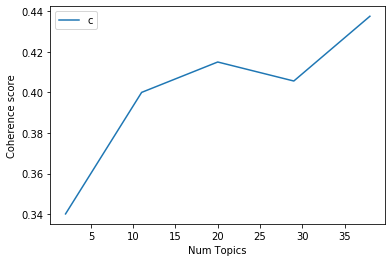

In [313]:
# Show graph
limit=40; start=2; step=9;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [314]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3402
Num Topics = 11  has Coherence Value of 0.4
Num Topics = 20  has Coherence Value of 0.4149
Num Topics = 29  has Coherence Value of 0.4056
Num Topics = 38  has Coherence Value of 0.4374


In [315]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(27,
  '0.116*"list" + 0.081*"review" + 0.052*"daily" + 0.047*"monthly" + '
  '0.043*"work" + 0.037*"approve" + 0.035*"department" + 0.030*"note" + '
  '0.029*"due_diligence" + 0.027*"stock"'),
 (12,
  '0.145*"complete" + 0.052*"advice" + 0.043*"case" + 0.040*"loss" + '
  '0.036*"event" + 0.034*"hold" + 0.033*"discuss" + 0.032*"aug" + 0.032*"jul" '
  '+ 0.023*"agree"'),
 (5,
  '0.102*"follow" + 0.062*"make" + 0.056*"action" + 0.047*"document" + '
  '0.041*"call" + 0.038*"margin" + 0.034*"review" + 0.029*"cmor" + '
  '0.027*"margin_call" + 0.025*"write"'),
 (23,
  '0.467*"customer" + 0.043*"dec" + 0.042*"confirm" + 0.041*"information" + '
  '0.028*"call" + 0.028*"rm" + 0.026*"impact" + 0.024*"contact" + '
  '0.020*"amend" + 0.018*"document"'),
 (8,
  '0.200*"bank" + 0.086*"request" + 0.049*"fund" + 0.046*"receive" + '
  '0.043*"feb" + 0.040*"swift" + 0.037*"beneficiary" + 0.029*"inform" + '
  '0.027*"credit" + 0.024*"transfer"'),
 (26,
  '0.217*"process" + 0.132*"checker" + 0.090*"cont

In [316]:
len(model_topics)

10

In [317]:
len(issueAction_df['Process1'].unique())

126

In [318]:
# Time for External Events

In [2]:
# Processing External Events
external_df_init = pd.read_excel('data/ExternalEvents-from First Data.xlsx')
external_df = external_df_init.copy(deep=True)
external_df.columns = external_df.iloc[0]
external_df = external_df.iloc[1:,:]
external_df.reset_index(drop=True, inplace=True)

In [3]:
bis_event_type = external_df['BIS Event Type']

In [4]:
cleaned_bis_event_type = []
for i in range(0, len(bis_event_type)):
    cleaned_bis_event_type.append(bis_event_type[i].split('\\')[0])
    
external_df['BIS Event Type'] = cleaned_bis_event_type    

In [5]:
external_df.dropna(subset=['Source'], how='all', inplace = True)
external_df = external_df.reset_index(drop=True)

In [13]:
corpus_external = []
for i in range(0, external_df.shape[0]):
    desc = re.sub('[^a-zA-Z]', ' ', external_df['Source'][i])
    corpus_external.append(textAnalyze(desc))

In [14]:
len(corpus_external)

16900

In [15]:
# Creating the Bag of Words
# Using CountVectorizer
cv_external = CountVectorizer(max_features=5000, ngram_range=(1,2))
X = cv_external.fit_transform(corpus_external).toarray()

# Using Term Frequency Inverse Document Frequency
tfidf_external = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
TX = tfidf_external.fit_transform(corpus_external).toarray()

feature_names_external = cv_external.get_feature_names()
feature_matrix_cv_external = pd.DataFrame(X, columns=feature_names_external)
feature_matrix_tfidf_external = pd.DataFrame(TX, columns=feature_names_external)

In [16]:
feature_matrix_cv_external.head()

,aap,aaron,aaron lucchetti,ab,abb,abbey,abc,abc news,abn,abn amro,...,za,zealand,zealand herald,zeitung,zhang,zibel,zions,zrt,zuckerman,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense

In [18]:
count_vect = CountVectorizer(max_features=40000)
X = count_vect.fit_transform(corpus_external).toarray()

In [19]:
y = pd.DataFrame(external_df['BIS Event Type'])

In [20]:
y.head()

,BIS Event Type
0,Internal Fraud
1,Clients Products and Business Practices
2,Internal Fraud
3,Clients Products and Business Practices
4,Execution Delivery and Process Management


In [21]:
# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y['BIS Event Type'] = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder(categorical_features = [0])
y = onehotencoder.fit_transform(y).toarray()

/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/abhigyansingh/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [22]:
# Split into Train Test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 40000))

# Adding the second hidden layer
classifier.add(Dense(units = 10000, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the third hidden layer
classifier.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10
13520/13520 [==============================] - 172s 13ms/step - loss: 0.2475 - acc: 0.9082
Epoch 2/10
13520/13520 [==============================] - 169s 12ms/step - loss: 0.1695 - acc: 0.9359
Epoch 3/10
13520/13520 [==============================] - 168s 12ms/step - loss: 0.1238 - acc: 0.9547
Epoch 4/10
13520/13520 [==============================] - 169s 13ms/step - loss: 0.0958 - acc: 0.9665
Epoch 5/10
13520/13520 [==============================] - 167s 12ms/step - loss: 0.0776 - acc: 0.9732
Epoch 6/10
13520/13520 [==============================] - 185s 14ms/step - loss: 0.0635 - acc: 0.9785
Epoch 7/10
13520/13520 [==============================] - 201s 15ms/step - loss: 0.0568 - acc: 0.9808
Epoch 8/10
13520/13520 [==============================] - 198s 15ms/step - loss: 0.0499 - acc: 0.9831
Epoch 9/10
13520/13520 [==============================] - 209s 15ms/step - loss: 0.0452 - acc: 0.9845
Epoch 10/10
13520/13520 [==============================] - 175s 13ms/step - loss: 

In [36]:
y_pred = classifier.predict(X_test)

In [37]:
y_pred = (y_pred > 0.5).astype(int)

In [38]:
y_pred_ar = []
for i in range(1, 3380):
    y_pred_ar.append(np.where(y_test[i]==1)[0][0])

In [39]:
y_pred_ar = []
for i in range(0, 3380):
    try:
        y_pred_ar.append(np.where(y_pred[i]==1)[0][0])
    except:
        y_pred_ar.append(-1)

In [40]:
y_test_ar = []
for i in range(0, 3380):
    try:
        y_test_ar.append(np.where(y_test[i]==1)[0][0])
    except:
        y_test_ar.append(-1)

In [41]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test_ar, y_pred_ar)

In [42]:
print(accuracy_score(y_test_ar, y_pred_ar))

0.6482248520710059
